Code credit: 
- This code forms the backbone of the program: https://github.com/tanvipenumudy/Winter-Internship-Internity/blob/main/Day%2009/Day-9%20Notebook-1%20(Decision%20Tree).ipynb

- This code uses decision trees on continuous values: https://towardsdatascience.com/regression-tree-in-python-from-scratch-9b7b64c815e3

- This code is specific to implementing random forests: https://carbonati.github.io/posts/random-forests-from-scratch/

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import time
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

## Create a Timer Class

In [2]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self,not_quiet=1):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        if not_quiet:
            print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return elapsed_time

## Read Data

In [181]:
df = pd.read_excel('test_data.xlsx',sheet_name='Training')
df = df.drop(['Data Series Name'],axis=1)

#df = df.loc[:, (df != 0).any(axis=0)]
#df.to_csv('input_file.csv')
#df.head()

y = df['Orders'].values
X = df.drop('Orders', axis=1).values
feat_names = df.drop('Orders', axis=1).columns.values

## Creating a Decision Tree Class

In [4]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [5]:
class decision_tree():
    
    def __init__(
        self, 
        min_samples_split=2,
        max_depth=None,
        n_feats=None,
        feat_names = None
    ):
        self.min_samples_split = min_samples_split
        if max_depth == None:
            self.max_depth = np.Inf
        else:
            self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.feat_names = feat_names

    def fit(self, X, y):
        #X = X[:, ~(X == X[0,:]).all(0)] #removes all columns where values are the same throughout
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow_tree(X, y)
    
    #Data processing for numeric columns - get the means of neighbours 
    def ma(self, X: np.array, window: int):
        return np.convolve(X, np.ones(window), 'valid') / window
    
    #Function to find the mse
    def get_mse(self, y, X_column, split):
        left_idxs = np.argwhere(X_column <= split).flatten()
        right_idxs = np.argwhere(X_column > split).flatten()
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return np.inf 
        
        n = len(left_idxs)+len(right_idxs)
        l_r, r_r = (y[left_idxs] - np.mean(y[left_idxs]))**2, (y[right_idxs] - np.mean(y[right_idxs]))**2
        mse = (sum(l_r) + sum(r_r))/n
        return mse

    #Function to find the best feature and split 
    def best_value(self, mse_base, X, y, feat_idxs):
    
        best_feature, best_split = None, None
                
        for feat_idx in feat_idxs: 
            X_column = X[:, feat_idx]
            splits = self.ma(np.unique(X_column[X_column.argsort()]),2)
            for split in splits: 
                mse_split = self.get_mse(y, X_column, split)
                if mse_split < mse_base:
                    best_feature = feat_idx
                    best_split = split
                    mse_base = mse_split
                    
        return (best_feature,best_split)
    
    def grow_tree(self, X, y, depth=0):
        #X = X[:, ~(X == X[0,:]).all(0)] #removes all columns where values are the same throughout
        
        n_samples, n_features = X.shape
        #print (X.shape)
        mse_base = sum((y-np.mean(y))**2)/len(y)
        
        #Stopping criteria 
        if (depth > self.max_depth) or (n_samples <= self.min_samples_split):
            return Node(value=np.mean(y))
         
        #Pick features randomly 
        feat_idxs = np.random.choice(n_features, min(self.n_feats,n_features), replace=False)
        
        best_feature, best_split = self.best_value(mse_base, X, y, feat_idxs)

        #If parent is better than the child
        if (best_feature is None):
            return Node(value=np.mean(y))
        
        #Otherwise, get left and right nodes 
        left_idxs, right_idxs = np.argwhere(X[:, best_feature] <= best_split).flatten(), np.argwhere(X[:, best_feature] > best_split).flatten()        
        
        #Create the left and right nodes
        left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feature, best_split, left, right)
        
            
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def print_info(self,node,node_type,depth):
        const = int(depth * 4 ** 1.5)
        spaces = "-" * const
        if node.is_leaf_node():
            print ('-' * const, "|", node_type, "LEAF: ", round(node.value,2))
        else:
            print ('-' * const, "|", node_type, "NODE: ", self.feat_names[node.feature], ",", "threshold:",round(node.threshold,2))
            
    
    def print_tree(self,node = None,depth=0):
        
        if node is None:
            node = self.root
            self.print_info(node,"ROOT",depth)
            depth += 1
        if node.left is not None:
            self.print_info(node.left,"L",depth)
            self.print_tree(node.left,depth+1)
        if node.right is not None:
            self.print_info(node.right,"R",depth)
            self.print_tree(node.right,depth+1)

## Creating Functions for a Random Forest

In [6]:
#Bootstrapping function 

def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train[bootstrap_indices,:]
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train[oob_indices,:]
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

In [7]:
from sklearn.metrics import mean_squared_error as mse

def rmse(a,p):
    return np.sqrt(mse(a,p))

In [8]:
def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    clf_ls = list()
    oob_ls = list()
    train_ls = list()
    for i in range(n_estimators):
        #Draw bootstrap sample
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        
        #Fit the tree and append tree to list
        clf = decision_tree(min_samples_split = min_samples_split, max_depth = max_depth,n_feats = max_features)
        clf.fit(X_bootstrap, y_bootstrap)
        clf_ls.append(clf)
        
        #Find validation (out of bag) error
        oob_pred = clf.predict(X_oob)
        oob_error = rmse(y_oob,oob_pred)
        oob_ls.append(oob_error)
        
        #Find training error
        train_pred = clf.predict(X_bootstrap)
        train_error = rmse(y_bootstrap,train_pred)
        train_ls.append(train_error)
    #print("OOB error: {:.2f}".format(np.mean(oob_ls)))
    return clf_ls, np.mean(oob_ls), np.mean(train_ls)

In [9]:
def predict_forest(clf_ls,X_test):
    n_estimators = len(clf_ls)
    y_pred_ls = np.empty([X_test.shape[0],n_estimators])
    for i in range(n_estimators):
        clf = clf_ls[i]
        y_pred = clf.predict(X_test)
        y_pred_ls[:,i] = y_pred
    return y_pred_ls.mean(axis=1)

## Test the Decision Tree Functions

In [10]:
#Split into train and test set 

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=889)

In [11]:
clf = decision_tree(feat_names = feat_names)

In [12]:
#import warnings
#warnings.filterwarnings('error')
clf.fit(X_train,y_train)

In [13]:
clf.print_tree()

 | ROOT NODE:  Feature_9 , threshold: 0.47
-------- | L NODE:  Feature_16 , threshold: 0.5
---------------- | L NODE:  Feature_21 , threshold: 69364.5
------------------------ | L NODE:  Feature_68 , threshold: 187762.5
-------------------------------- | L NODE:  Feature_75 , threshold: 16.5
---------------------------------------- | L NODE:  Feature_27 , threshold: 1470482.0
------------------------------------------------ | L NODE:  Feature_69 , threshold: 241364.5
-------------------------------------------------------- | L NODE:  Feature_22 , threshold: 8197236.0
---------------------------------------------------------------- | L NODE:  Feature_28 , threshold: 179236.5
------------------------------------------------------------------------ | L NODE:  Feature_67 , threshold: 13263.0
-------------------------------------------------------------------------------- | L NODE:  Feature_28 , threshold: 22622.0
-----------------------------------------------------------------------------

In [14]:
y_pred = clf.predict(X_val)

RMSE of validation set using decision tree:  1129.43


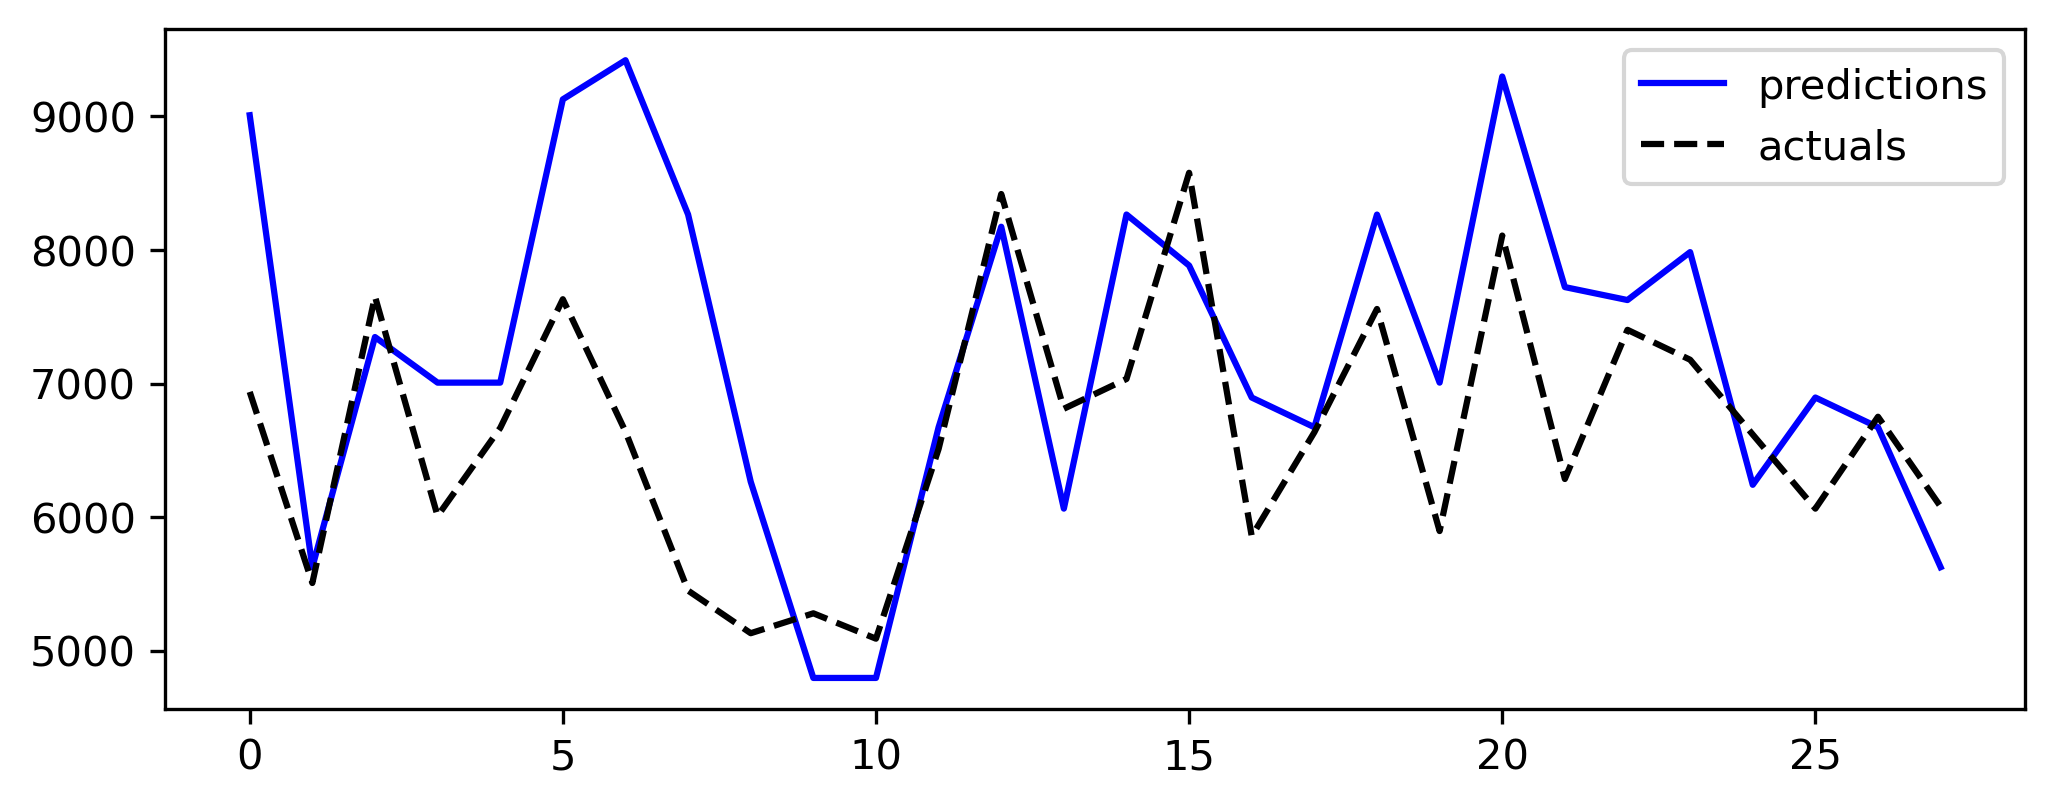

In [15]:
fig = plt.figure(figsize=(8,3),dpi=300)

plt.plot(range(0,len(y_pred)), y_pred, 'b-', label = "predictions")
plt.plot(range(0,len(y_val)), y_val, 'k--', label = "actuals")
plt.legend()

df = pd.DataFrame({"predictions" : y_pred, "actuals" : y_val})
print("RMSE of validation set using decision tree: ", round(rmse(y_val,y_pred),2))

## Test the Random Forest Functions

In [16]:
n_estimators = 100
max_features = 40
max_depth = 10
min_samples_split = 2

model,oob_error,train_error = random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split)

In [17]:
y_pred = predict_forest(model,X_val)

RMSE of validation set using random forest:  812.97


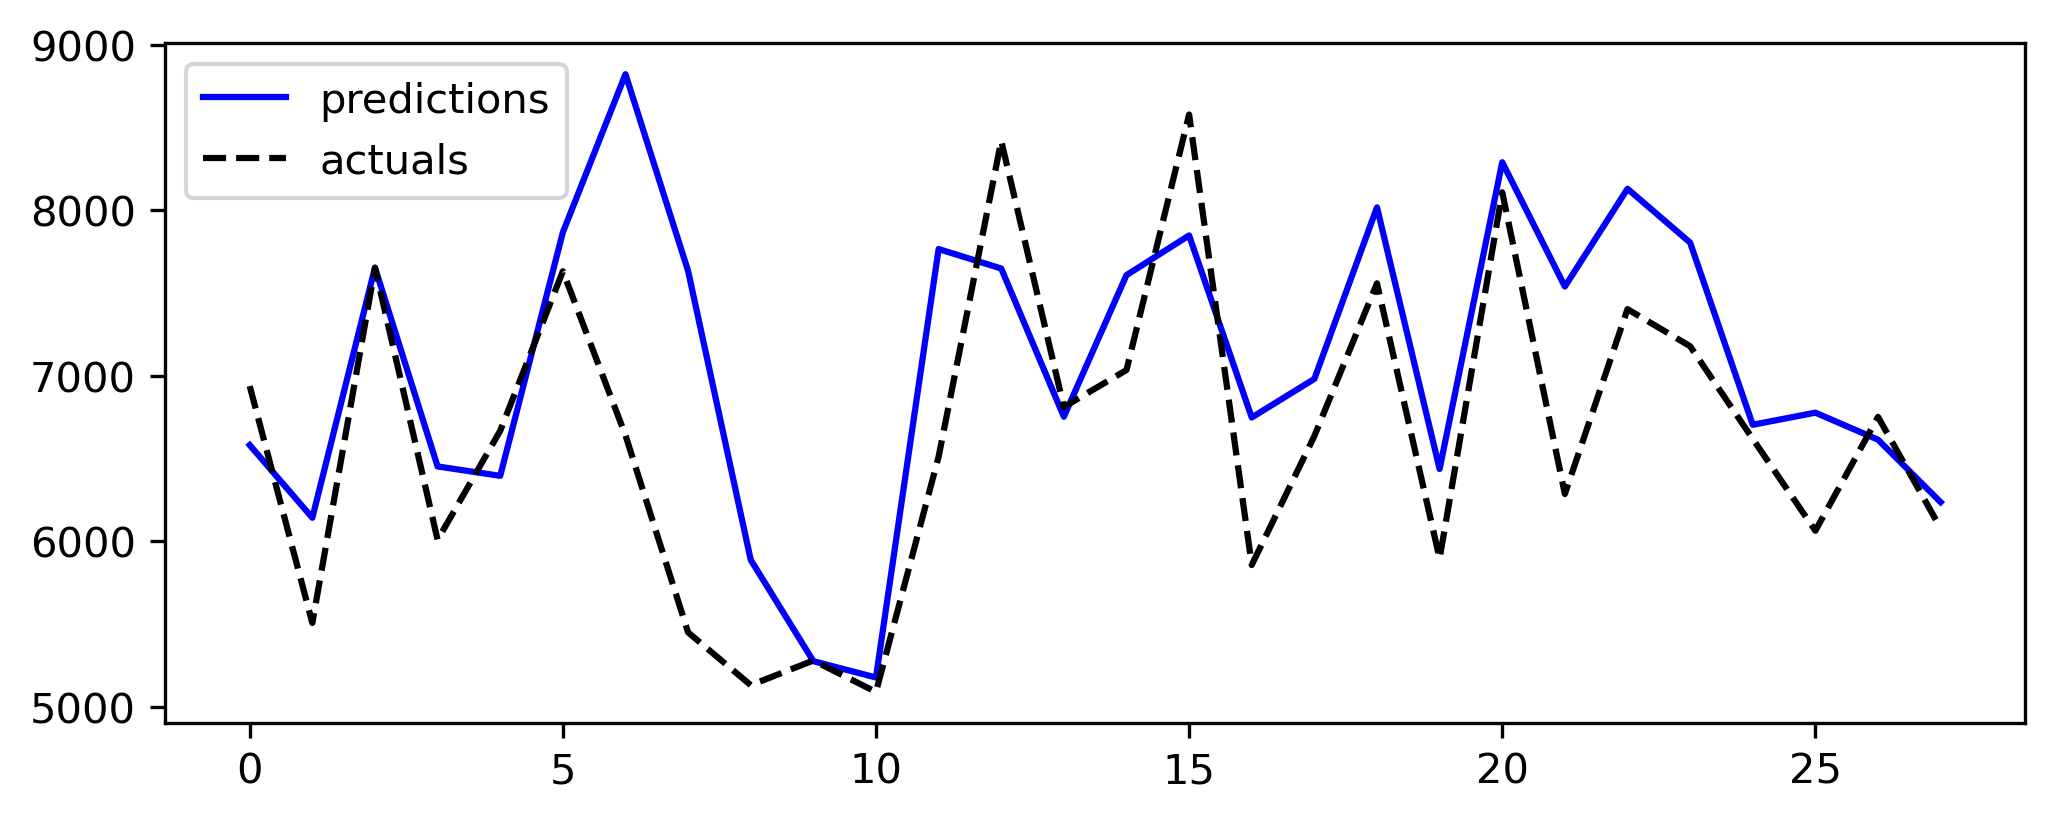

In [18]:
fig = plt.figure(figsize=(8,3),dpi=300)

plt.plot(range(0,len(y_pred)), y_pred, 'b-', label = "predictions")
plt.plot(range(0,len(y_val)), y_val, 'k--', label = "actuals")
plt.legend()

#df = pd.DataFrame({"predictions" : y_pred, "actuals" : y_val})
print("RMSE of validation set using random forest: ", round(rmse(y_val,y_pred),2))

## Varying error across hyperparameters

#### Number of features randomly selected

In [19]:
n_estimators = 100
max_depth = None
min_samples_split = 2
n_features = [10,20,40,75]
feature_vrmse = {}
feature_trmse = {}

for feat in n_features:
    t = Timer()
    t.start()
    model, val_error, train_error  = random_forest(X_train, y_train, n_estimators, feat, max_depth, min_samples_split)
    val_pred = predict_forest(model,X_val)
    train_pred = predict_forest(model,X_train) 
    feature_vrmse[feat] = round(rmse(y_val,val_pred),2)
    feature_trmse[feat] = round(rmse(y_train,train_pred),2)
    print (feat, t.stop(0))

10 41.354352300000016
20 82.46049150000002
40 153.9845034
75 264.75111390000006


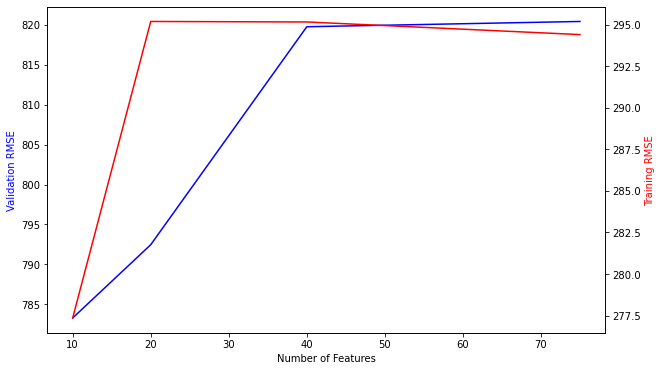

In [20]:
plt.figure(figsize=(10,6))
plt.plot(feature_vrmse.keys(),feature_vrmse.values(),'b-',label='Validation')
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE',color='Blue')
ax1 = plt.twinx()
ax1.plot(feature_trmse.keys(),feature_trmse.values(),'r-',label='Training')
plt.ylabel('Training RMSE',color='Red')
plt.show()

#### Min samples per leaf 

In [21]:
n_estimators = 100
max_depth = None
min_samples_split = [5,10,20,40,60]
leaf_vrmse = {}
leaf_trmse = {}
n_features =  20

for sample_split in min_samples_split:
    t = Timer()
    t.start()
    model, val_error, train_error  = random_forest(X_train, y_train, n_estimators, n_features, max_depth, sample_split)
    val_pred = predict_forest(model,X_val)
    train_pred = predict_forest(model,X_train)
    leaf_vrmse[sample_split] = round(rmse(y_val,val_pred),2)
    leaf_trmse[sample_split] = round(rmse(y_train,train_pred),2)
    print (sample_split, t.stop(0))

5 60.298193200000014
10 48.973978699999975
20 38.54148870000006
40 26.834503799999993
60 16.774830199999997


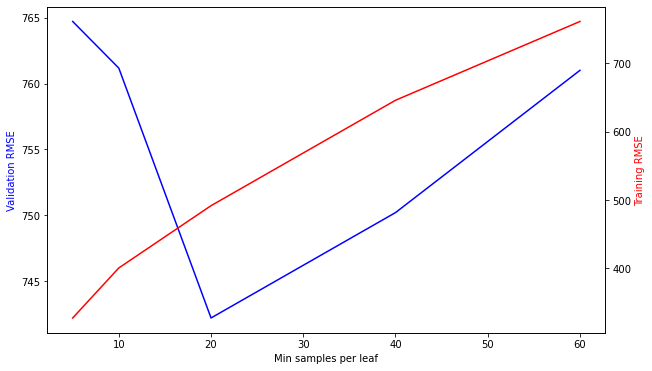

In [22]:
plt.figure(figsize=(10,6))
plt.plot(leaf_vrmse.keys(),leaf_vrmse.values(),'b-',label='Validation')
plt.xlabel('Min samples per leaf')

plt.ylabel('Validation RMSE',color='Blue')
ax1 = plt.twinx()
plt.plot(leaf_trmse.keys(),leaf_trmse.values(),'r-',label='Training')

#plt.legend()
plt.ylabel('Training RMSE',color='Red')
plt.show()

#### Number of Trees in Forest

In [23]:
n_estimators = [100,200,500,1000]
max_depth = None
min_samples_split = 10
estimator_vrmse = {}
estimator_trmse = {}
n_features =  20

for n_estimator in n_estimators:
    t = Timer()
    t.start()
    model, val_error, train_error  = random_forest(X_train, y_train, n_estimator, n_features, max_depth, min_samples_split)
    val_pred = predict_forest(model,X_val)
    train_pred = predict_forest(model,X_train)
    estimator_vrmse[n_estimator] = round(rmse(y_val,val_pred),2)
    estimator_trmse[n_estimator] = round(rmse(y_train,train_pred),2)
    print (n_estimator, t.stop(0))

100 49.740100400000074
200 98.87349659999995
500 1035.8797903
1000 497.2615725999999


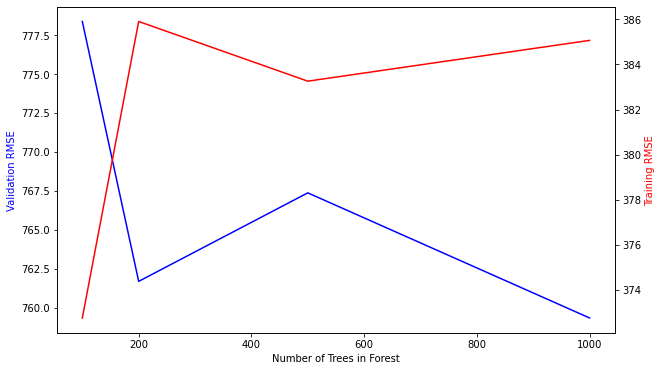

In [24]:
plt.figure(figsize=(10,6))
plt.plot(estimator_vrmse.keys(),estimator_vrmse.values(),'b-',label='Validation')
plt.xlabel('Number of Trees in Forest')
plt.ylabel('Validation RMSE',color='Blue')
ax1 = plt.twinx()
plt.plot(estimator_trmse.keys(),estimator_trmse.values(),'r-',label='Training')
plt.ylabel('Training RMSE',color='Red')
#plt.legend()
plt.show()

#### Max Depth

In [25]:
n_estimators = 200
depths = [3,5,10,20]
min_samples_split = 2
depth_vrmse = {}
depth_trmse = {}
n_features =  20

for depth in depths:
    t = Timer()
    t.start()
    model, val_error, train_error  = random_forest(X_train, y_train, n_estimators, n_features, depth, min_samples_split)
    val_pred = predict_forest(model,X_val)
    train_pred = predict_forest(model,X_train)
    depth_vrmse[depth] = round(rmse(y_val,val_pred),2)
    depth_trmse[depth] = round(rmse(y_train,train_pred),2)
    print (depth, t.stop(0))

3 75.12800010000001
5 107.71869780000043
10 147.90010680000023
20 140.74671420000004


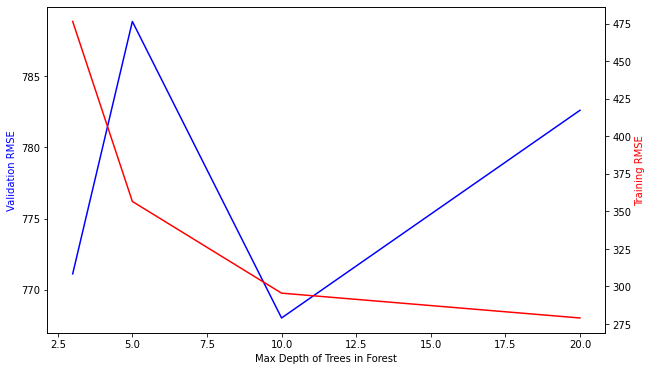

In [26]:
plt.figure(figsize=(10,6))
plt.plot(depth_vrmse.keys(),depth_vrmse.values(),'b-',label='Validation')
plt.xlabel('Max Depth of Trees in Forest')
plt.ylabel('Validation RMSE',color='Blue')
ax1 = plt.twinx()
ax1.plot(depth_trmse.keys(),depth_trmse.values(),'r-',label='Training')
plt.ylabel('Training RMSE',color='Red')
plt.show()

## External validation set

In [27]:
#Random Forest
rf_model, val_error, train_error = random_forest(X_train, y_train, n_estimators=200, max_features=20, max_depth=3,min_samples_split=10)
y_pred_rf = predict_forest(rf_model,X_val)

#Decision Tree 
dt_model = decision_tree(feat_names = feat_names)
dt_model.fit(X_train,y_train)
y_pred_dt = dt_model.predict(X_val)

#SKLearn 
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred_skl = regressor.predict(X_val)

RMSE of validation set using random forest:  776.57
RMSE of validation set using decision tree:  1063.83
RMSE of validation set using SKLearns random forest:  778.61


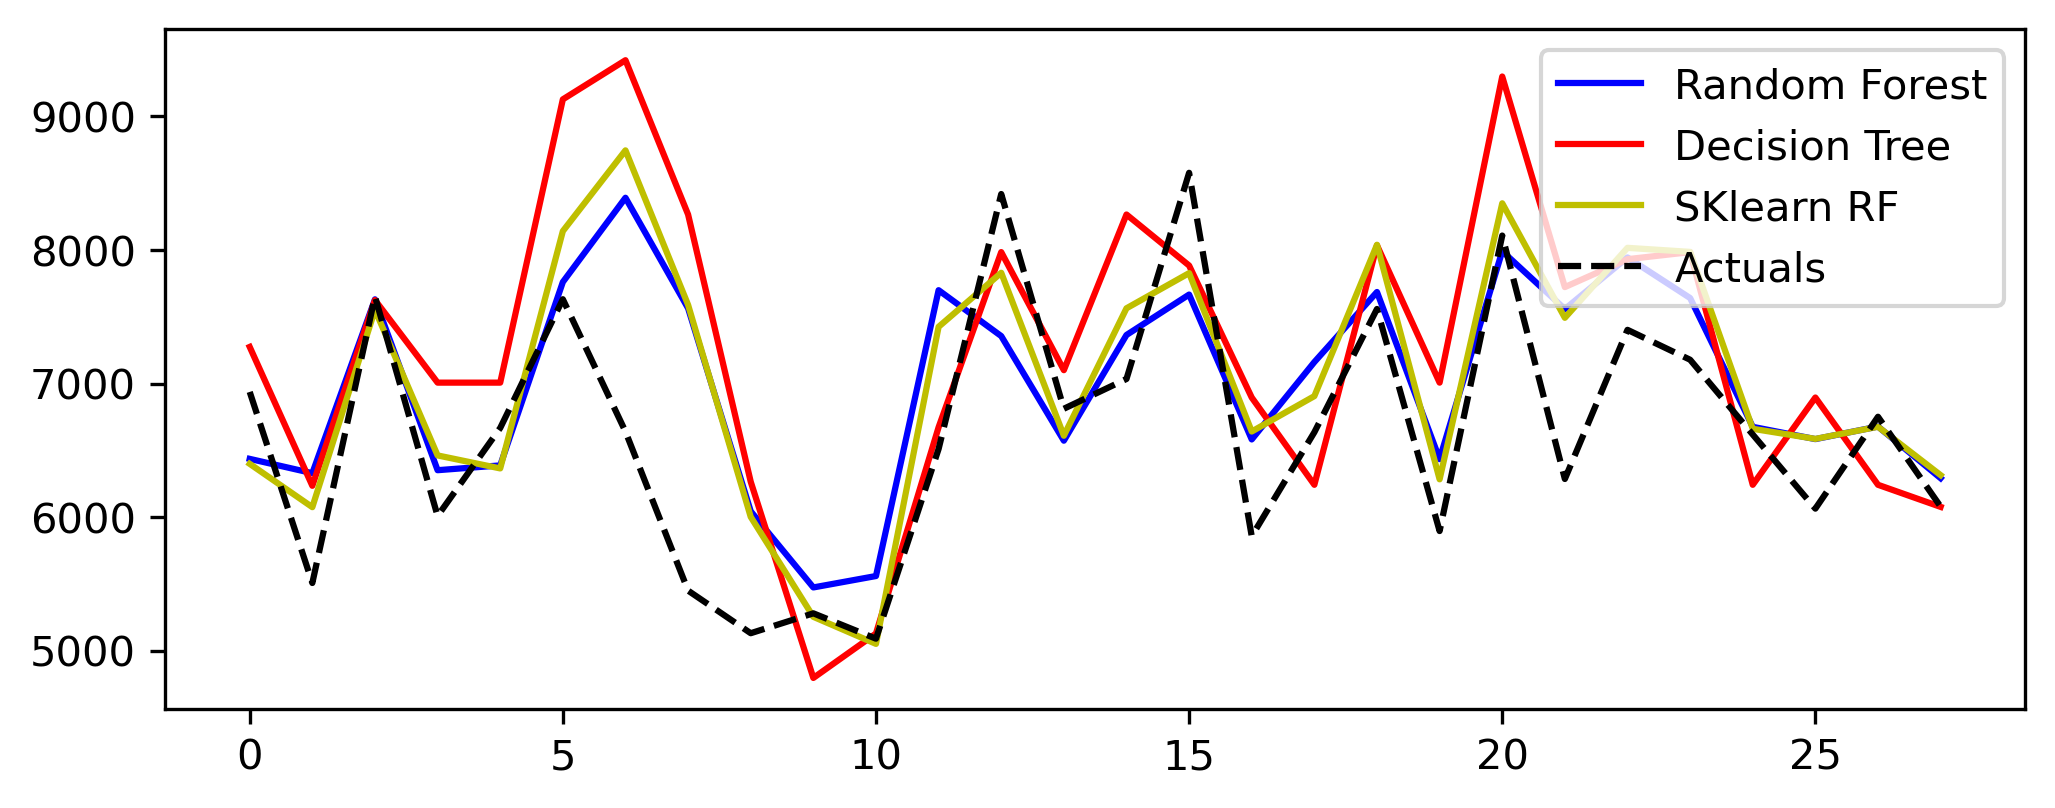

In [28]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(range(0,len(y_pred_rf)), y_pred_rf, 'b-', label = "Random Forest")
plt.plot(range(0,len(y_pred_dt)), y_pred_dt, 'r-', label = "Decision Tree")
plt.plot(range(0,len(y_pred_skl)), y_pred_skl, 'y-', label = "SKlearn RF")
plt.plot(range(0,len(y_val)), y_val, 'k--', label = "Actuals")
plt.legend()

print("RMSE of validation set using random forest: ", round(rmse(y_val,y_pred_rf),2))
print("RMSE of validation set using decision tree: ", round(rmse(y_val,y_pred_dt),2))
print("RMSE of validation set using SKLearns random forest: ", round(rmse(y_val,y_pred_skl),2))

## Test set

In [29]:
test_data = pd.read_excel('test_data.xlsx',sheet_name="Test") #mysterious test data
y_actual = np.array([8298,9820,9852,7850,8082,8179,9042,8025,6966,7985,8505,8023,6814,7674,9514,8336,6326,6440,4759,4837])
test = test_data.iloc[:,2:].values

In [30]:
#Random Forest with chosen paramaters
rf_model_1, val_error, train_error  = random_forest(X, y, n_estimators=200, max_features=20, max_depth=3, min_samples_split=10)
y_pred_rf_1 = predict_forest(rf_model_1,test)

#Random Forest with default paramaters 
rf_model_2, val_error, train_error  = random_forest(X, y, n_estimators=200, max_features=X.shape[1], max_depth=None, min_samples_split=1)
y_pred_rf_2 = predict_forest(rf_model_2,test)

#Decision Tree 
dt_model = decision_tree(feat_names = feat_names)
dt_model.fit(X,y)
y_pred_dt = dt_model.predict(test)

#SKLearn 
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X, y)
y_pred_skl = regressor.predict(test)

RMSE of test set using RF-set hyperparameters:  1194.64
RMSE of test set using RF-default hyperparameters:  891.67
RMSE of test set using decision tree:  1551.17
RMSE of test set using SKLearns random forest:  883.39


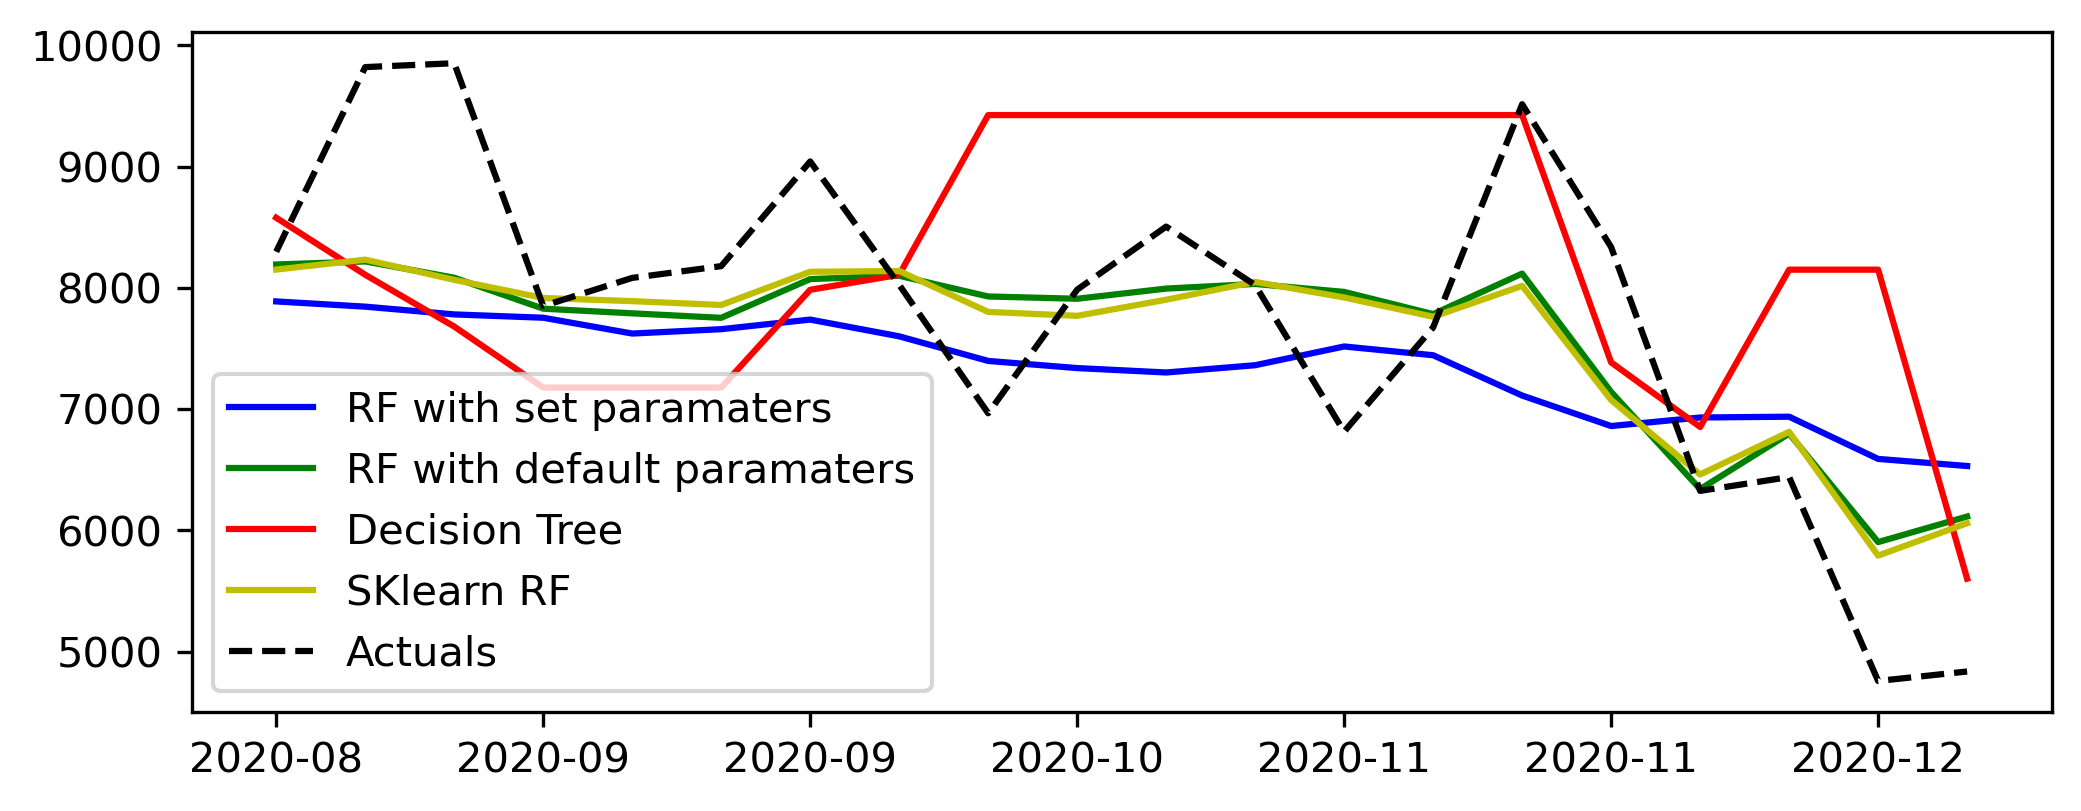

In [31]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.gca().set_xticks(range(0,20,3))
plt.gca().set_xticklabels(pd.date_range(start=test_data.iloc[0,0],end=test_data.iloc[-1,0],freq='W')[range(0,20,3)].map(lambda x:x.strftime("%Y-%m")))
plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_1, 'b-', label = "RF with set paramaters")
plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_2, 'g-', label = "RF with default paramaters")
plt.plot(range(0,len(y_pred_dt)), y_pred_dt, 'r-', label = "Decision Tree")
plt.plot(range(0,len(y_pred_skl)), y_pred_skl, 'y-', label = "SKlearn RF")
plt.plot(range(0,len(y_actual)), y_actual, 'k--', label = "Actuals")
plt.legend()

print("RMSE of test set using RF-set hyperparameters: ", round(rmse(y_actual,y_pred_rf_1),2))
print("RMSE of test set using RF-default hyperparameters: ", round(rmse(y_actual,y_pred_rf_2),2))
print("RMSE of test set using decision tree: ", round(rmse(y_actual,y_pred_dt),2))
print("RMSE of test set using SKLearns random forest: ", round(rmse(y_actual,y_pred_skl),2))

## Random Search to Tune Hyperparameters 

- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Code: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb
- Random Search > Grid Search: https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85
- Changing scoring to RMSE: https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv

In [119]:
from sklearn.model_selection import RandomizedSearchCV
import random
from scipy.stats import truncnorm
from pprint import pprint
import sys

#### Initialize search space and perform randomized search

In [107]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [108]:
rf = RandomForestRegressor()

**Regarding n_iter and cv in randomizedsearchcv:** More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.

In [109]:
""" Scoring: Changed to mean squared error instead of R^2
    n_iter: Number of combinations to look at
    cv: Number of folds
    n_jobs: all CPUs are put to use
"""

rf_random = RandomizedSearchCV(scoring="neg_mean_squared_error", estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [110]:
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [111]:
pprint(rf_random.best_params_)
print("RMSE with best parameters: ", round(np.sqrt(-rf_random.best_score_),2))

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}
RMSE with best parameters:  873.15


#### Evaluate the best parameters

In [112]:
best_random = rf_random.best_estimator_
y_pred_randomsearch = best_random.predict(test)

In [113]:
print("RMSE of test set using random search: ", round(rmse(y_actual,y_pred_randomsearch),2))

RMSE of test set using random search:  906.17


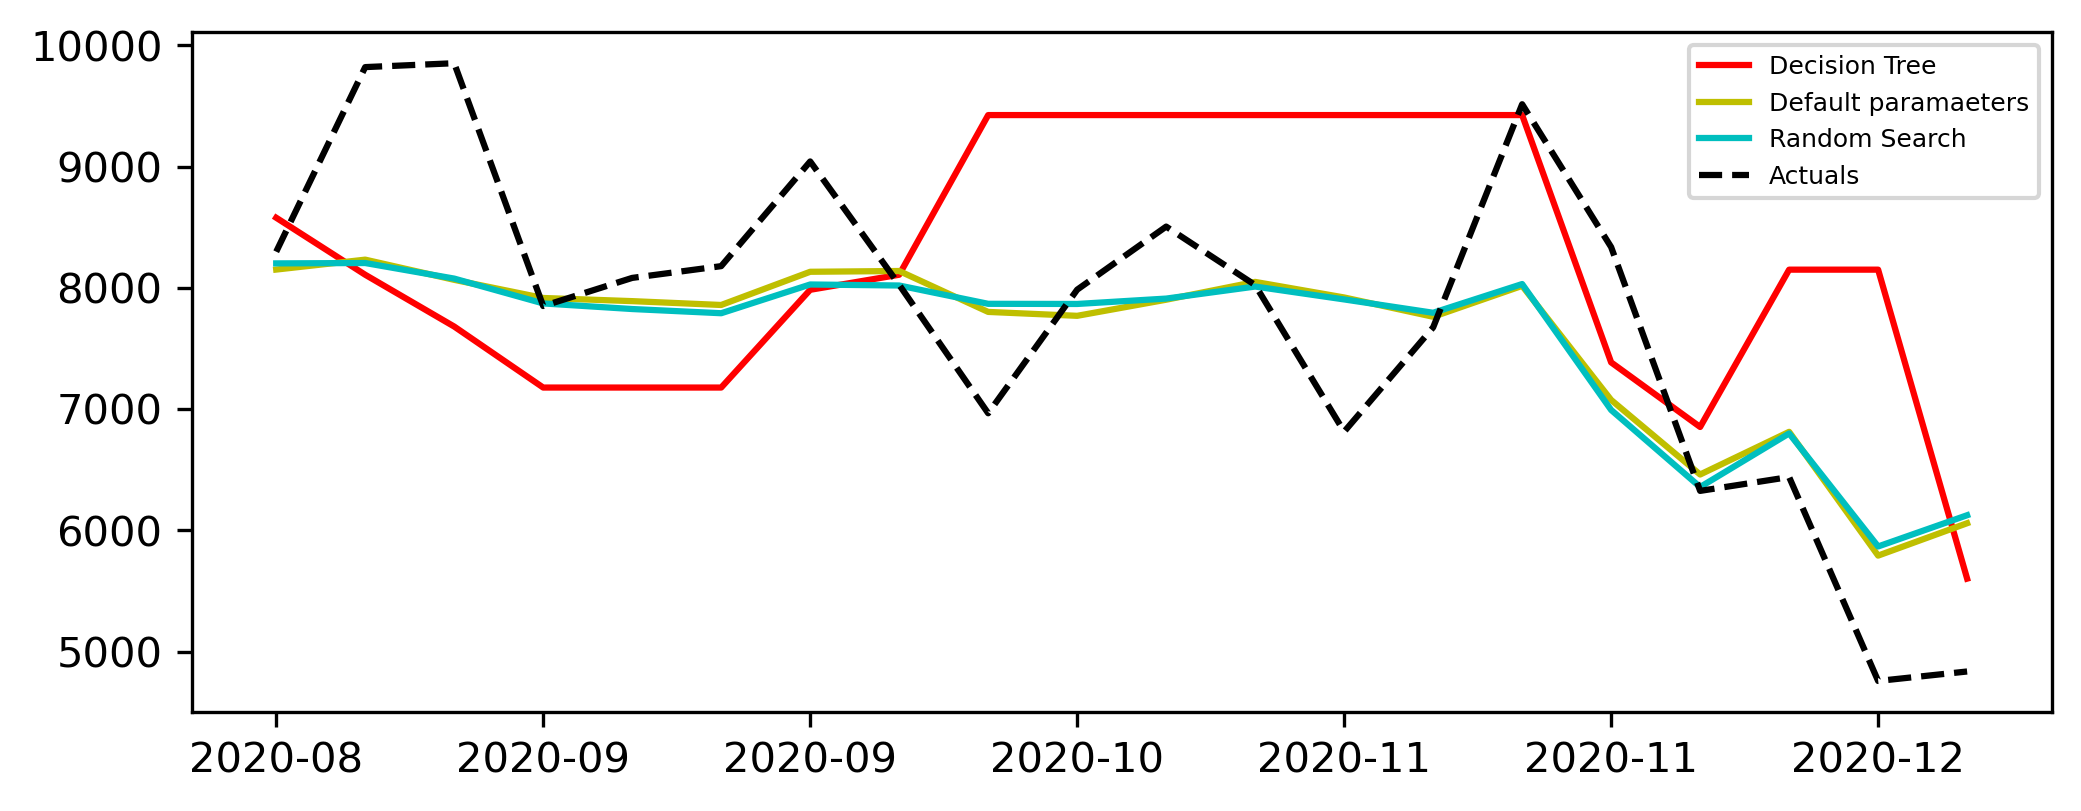

In [203]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.gca().set_xticks(range(0,20,3))
plt.gca().set_xticklabels(pd.date_range(start=test_data.iloc[0,0],end=test_data.iloc[-1,0],freq='W')[range(0,20,3)].map(lambda x:x.strftime("%Y-%m")))
#plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_1, 'b-', label = "RF with set paramaters")
#plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_2, 'g-', label = "RF with default paramaters")
plt.plot(range(0,len(y_pred_dt)), y_pred_dt, 'r-', label = "Decision Tree")
plt.plot(range(0,len(y_pred_skl)), y_pred_skl, 'y-', label = "Default paramaeters")
plt.plot(range(0,len(y_pred_randomsearch)), y_pred_randomsearch, 'c-', label = "Random Search")
plt.plot(range(0,len(y_actual)), y_actual, 'k--', label = "Actuals")
plt.legend(prop={'size': 6})

## Transforming Media Data

In [190]:
#Transform train data
X_media = X[:,18:80]
X_media_transform1 = np.pad(X_media,((1,0),(0,0)), mode='constant')[:-1,:]
X_media_transform2 = np.pad(X_media,((2,0),(0,0)), mode='constant')[:-2,:]

#Transform test data
test_media = test[:,18:80]
test_media_transform1 = np.pad(test_media,((1,0),(0,0)), mode='constant')[:-1,:]
test_media_transform2 = np.pad(test_media,((2,0),(0,0)), mode='constant')[:-2,:]

In [197]:
#Add transformed variables to train and test data
X_new = np.append(X, X_media_transform1, axis=1)
X_new = np.append(X_new, X_media_transform2, axis=1)

test_new = np.append(test, test_media_transform1, axis=1)
test_new = np.append(test_new, test_media_transform2, axis=1)

In [198]:
rf_random.fit(X_new, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [199]:
pprint(rf_random.best_params_)
print("Train RMSE with transformed media and best hyperparameters: ", round(np.sqrt(-rf_random.best_score_),2))

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}
Train RMSE with transformed media and best hyperparameters:  873.14


In [200]:
best_random = rf_random.best_estimator_
y_pred_randomSearch_mediaTransform = best_random.predict(test_new)
print("Test RMSE with transformed media and best hyperparameters: ", round(rmse(y_actual,y_pred_randomSearch_mediaTransform),2))

Test RMSE with transformed media and best hyperparameters:  915.25


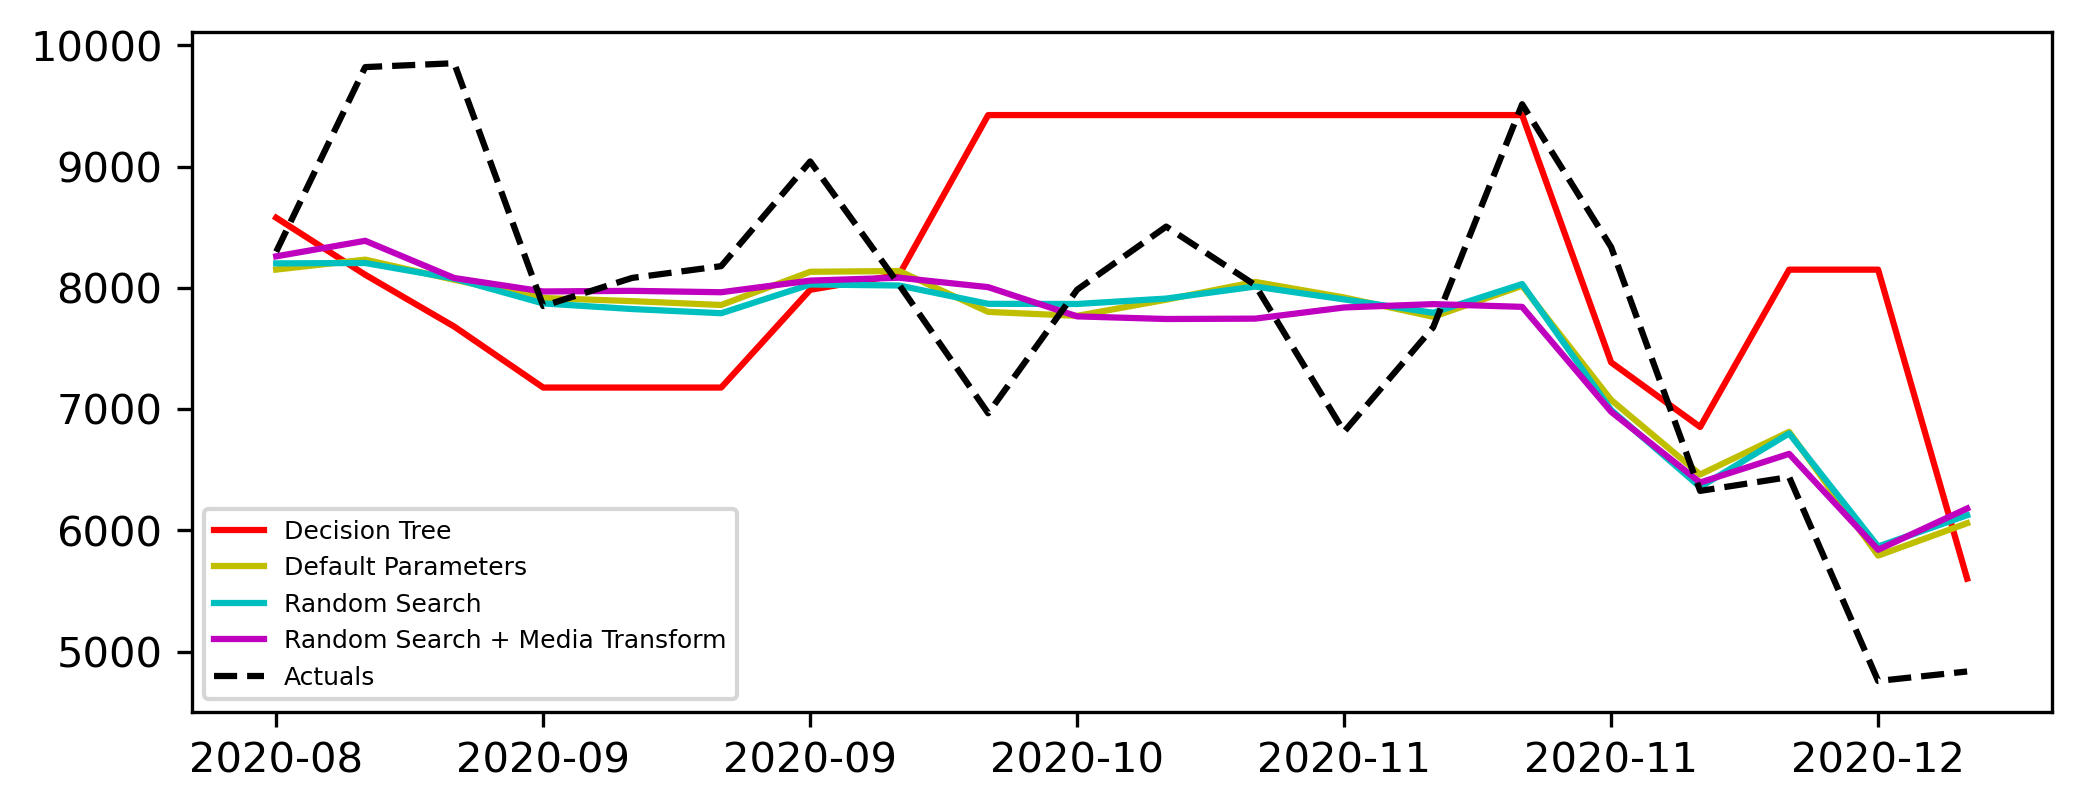

In [204]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.gca().set_xticks(range(0,20,3))
plt.gca().set_xticklabels(pd.date_range(start=test_data.iloc[0,0],end=test_data.iloc[-1,0],freq='W')[range(0,20,3)].map(lambda x:x.strftime("%Y-%m")))
#plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_1, 'b-', label = "RF with set paramaters")
#plt.plot(range(0,len(y_pred_rf_1)), y_pred_rf_2, 'g-', label = "RF with default paramaters")
plt.plot(range(0,len(y_pred_dt)), y_pred_dt, 'r-', label = "Decision Tree")
plt.plot(range(0,len(y_pred_skl)), y_pred_skl, 'y-', label = "Default Parameters")
plt.plot(range(0,len(y_pred_randomsearch)), y_pred_randomsearch, 'c-', label = "Random Search")
plt.plot(range(0,len(y_pred_randomSearch_mediaTransform)), y_pred_randomSearch_mediaTransform, 'm-', label = "Random Search + Media Transform")
plt.plot(range(0,len(y_actual)), y_actual, 'k--', label = "Actuals")
plt.legend(prop={'size': 6})